# Time Series Forecasting with ARIMAX, SARIMAX and PROPHET
## by Vesna Pop-Dimitrijoska
---

---
# EDA, Data Preprocessing and Data Engineering on WebTrafic dataset
## Separately per every device: desktop, mobile and tablet 

---

# Task

Time Series Forecasting with ARIMA, SARIMA and PROPHET the Web Traffic dataset for each device type (separately) and forecast the total cumulaive traffic. 

---
## Loading the libraries

In [1]:
import pandas as pd
import numpy as np
import itertools
import tqdm 
from summarytools import dfSummary
import matplotlib.pyplot as plt
import seaborn as sns
import os

#Time-series Forecasting
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import prophet

import warnings
warnings.filterwarnings('ignore')

## Read the Dataset

In [2]:
df_org = pd.read_csv('clean_LA_web_traffic.csv',index_col=0, parse_dates=['Date']).reset_index(drop=True)

In [3]:
df_desktop = df_org.loc[df_org['Device Category'] == 'desktop'].drop(columns='Device Category').set_index('Date').copy()
df_mobile = df_org.loc[df_org['Device Category'] == 'mobile'].drop(columns='Device Category').set_index('Date').copy()
df_tablet = df_org.loc[df_org['Device Category'] == 'tablet'].drop(columns='Device Category').set_index('Date').copy()
df_total = df_org.groupby('Date').sum(numeric_only=True)

## Exploratory Data Analysis

In [4]:
df_desktop.info()
print('\n\n')
df_mobile.info()
print('\n\n')
df_tablet.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2065 entries, 2014-01-01 to 2019-08-27
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Sessions  2065 non-null   int64
dtypes: int64(1)
memory usage: 32.3 KB



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2065 entries, 2014-01-01 to 2019-08-27
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Sessions  2065 non-null   int64
dtypes: int64(1)
memory usage: 32.3 KB



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2065 entries, 2014-01-01 to 2019-08-27
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Sessions  2065 non-null   int64
dtypes: int64(1)
memory usage: 32.3 KB


In [5]:
display(df_desktop.describe())
display(df_mobile.describe())
display(df_tablet.describe())

Sessions
count  2.065000e+03
mean   1.833020e+06
std    1.007320e+06
min    4.380000e+02
25%    9.990740e+05
50%    1.901969e+06
75%    2.553544e+06
max    1.506813e+07

Sessions
count  2.065000e+03
mean   8.195172e+05
std    6.264891e+05
min    5.570000e+02
25%    5.983400e+05
50%    7.796170e+05
75%    9.645290e+05
max    2.235053e+07

Sessions
count  2.065000e+03
mean   1.371213e+05
std    8.748275e+04
min    0.000000e+00
25%    8.082400e+04
50%    1.270100e+05
75%    1.847410e+05
max    1.799165e+06

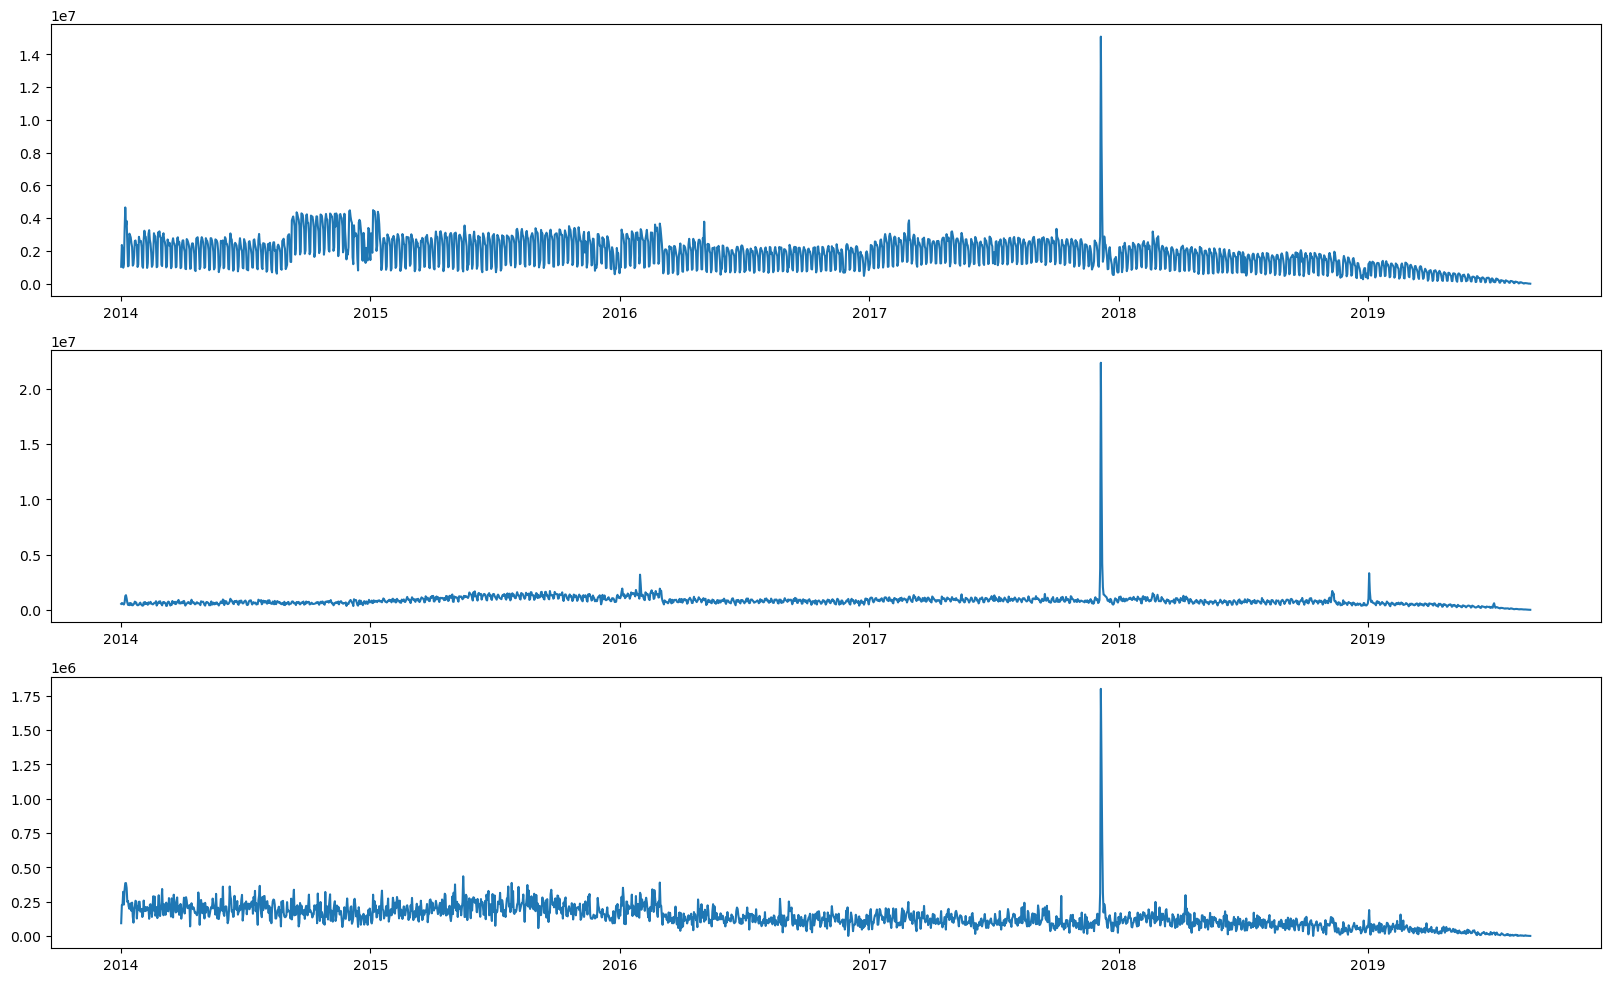

In [6]:
fig = plt.figure(figsize=(20,12))
plt.subplot(311)
plt.plot(df_desktop)
plt.subplot(312)
plt.plot(df_mobile)
plt.subplot(313)
plt.plot(df_tablet)
plt.show()

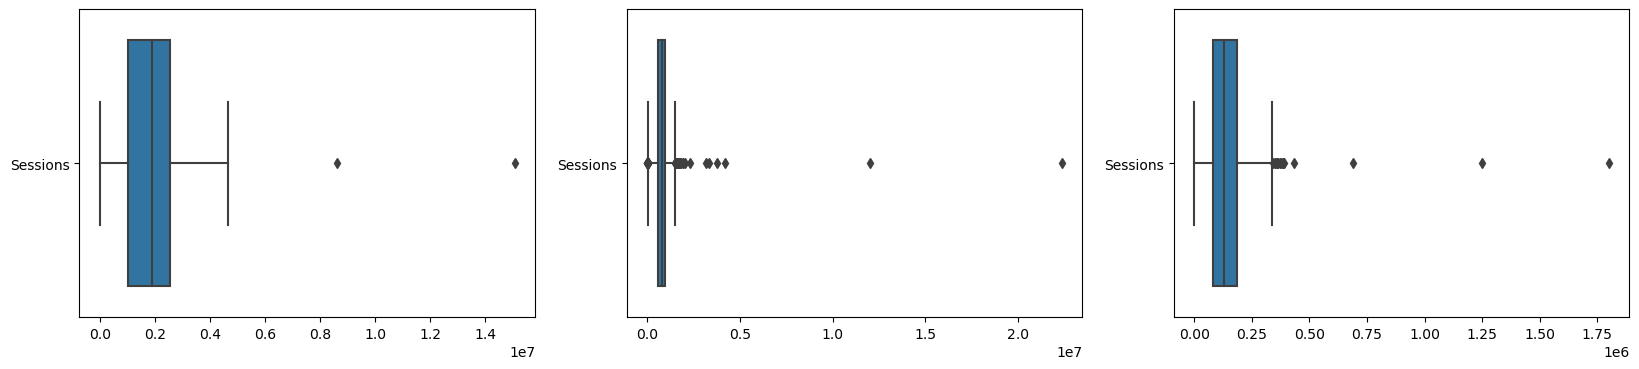

In [7]:
fig = plt.figure(figsize=(20,4))
plt.subplot(131)
sns.boxplot(df_desktop, orient='h')
plt.subplot(132)
sns.boxplot(df_mobile, orient='h')
plt.subplot(133)
sns.boxplot(df_tablet, orient='h')
plt.show()

---
## Handling Outliers 
### Removing the most extreme outliers and imputing them with mean value of the dataset
---

### Handling outliers for df_desktop

In [8]:
Q1 = np.percentile(df_desktop, 25)
Q3 = np.percentile(df_desktop, 75)
IQR = Q3 - Q1

L = Q1 - 1.5*IQR
U = Q3 + 1.5*IQR

df_desktop['Outlier'] = ((df_desktop['Sessions'] < L) | (df_desktop['Sessions'] > U))
df_desktop.loc[df_desktop['Outlier']==True]

Sessions  Outlier
Date                         
2017-12-06  15068131     True
2017-12-07   8605199     True

In [9]:
#df_desktop.loc[df_desktop['Outlier'] == True].replace(df_desktop['Sessions'], df_desktop['Sessions'].mean())

mean_sessions = df_desktop.loc[df_desktop['Outlier'] == False, 'Sessions'].mean()
df_desktop.loc[df_desktop['Outlier'] == True, 'Sessions'] = mean_sessions

df_desktop = df_desktop.drop(columns=['Outlier'])

### Handling outliers for df_mobile

In [10]:
Q1 = np.percentile(df_mobile, 25)
Q3 = np.percentile(df_mobile, 75)
IQR = Q3 - Q1

L = Q1 - 1.5*IQR
U = Q3 + 1.5*IQR

df_mobile['Outlier'] = ((df_mobile['Sessions'] < L) | (df_mobile['Sessions'] > U))
df_mobile.loc[df_mobile['Outlier']==True]

Sessions  Outlier
Date                         
2015-05-26   1568127     True
2015-06-01   1577485     True
2015-06-03   1666817     True
2015-06-09   1524584     True
2015-08-04   1596762     True
2015-08-10   1520929     True
2015-08-17   1543858     True
2015-08-24   1599215     True
2015-08-25   1579965     True
2015-09-01   1514956     True
2015-09-08   1603880     True
2015-09-09   1626183     True
2015-09-14   1611000     True
2015-09-15   1627203     True
2015-09-21   1697414     True
2015-09-28   1618836     True
2015-10-09   1581412     True
2016-01-04   1636895     True
2016-01-05   1922392     True
2016-01-18   1576386     True
2016-01-25   1797152     True
2016-01-26   1570836     True
2016-01-31   3180266     True
2016-02-01   2314423     True
2016-02-08   1584214     True
2016-02-16   1621433     True
2016-02-17   1765895     True
2016-02-19   1524606     True
2016-02-23   1702130     True
2016-02-29   1913777     True
2016-03-01   1661102     True
2016-03-02   1724750     True
2017-12-05   3747172     True
2017-12-06  22350530     True
2017-12-07  11990374     True
2017-12-08   4180594     True
2017-12-09   2050265     True
2018-11-10   1700454     True
2019-01-03   3310128     True
2019-01-04   1677584     True
2019-08-11     38976     True
2019-08-13     48546     True
2019-08-15     46341     True
2019-08-16     38812     True
2019-08-17     26309     True
2019-08-18     27279     True
2019-08-19     34470     True
2019-08-20     28123     True
2019-08-21     23832     True
2019-08-22     19111     True
2019-08-23     15734     True
2019-08-24      8225     True
2019-08-25      5965     True
2019-08-26      4893     True
2019-08-27       557     True

In [11]:
# Because there are too many outliers, I decided to replace only the most extreme ones

df_mobile.index = pd.to_datetime(df_mobile.index)

# Define a list of dates to be deleted
dates_to_replace = [
    '2017-12-05',
    '2017-12-06',
    '2017-12-07',
    '2017-12-08',
    '2017-12-09',
    '2019-01-03',
    '2019-01-04',
    '2016-01-31',
    '2016-02-01'
]

mean_mobile = df_mobile[~df_mobile.index.isin(dates_to_replace)]['Sessions'].mean()

# Replace the values for the specified dates with the mean value
for date in dates_to_replace:
    df_mobile.loc[df_mobile.index == date, 'Sessions'] = mean_mobile

df_mobile = df_mobile.drop(columns=['Outlier'])

### Handling outliers for df_tablet

In [12]:
Q1 = np.percentile(df_tablet, 25)
Q3 = np.percentile(df_tablet, 75)
IQR = Q3 - Q1

L = Q1 - 1.5*IQR
U = Q3 + 1.5*IQR

df_tablet['Outlier'] = ((df_tablet['Sessions'] < L) | (df_tablet['Sessions'] > U))
df_tablet.loc[df_tablet['Outlier']==True]

Sessions  Outlier
Date                         
2014-01-07    384097     True
2014-01-08    385173     True
2014-01-09    349221     True
2014-03-02    341880     True
2014-05-30    358961     True
2014-06-09    360021     True
2014-07-23    364850     True
2015-05-05    374944     True
2015-05-17    434273     True
2015-07-22    359678     True
2015-07-27    386022     True
2015-08-06    357191     True
2015-08-19    370704     True
2016-01-06    350687     True
2016-02-29    388649     True
2017-12-06   1799165     True
2017-12-07   1247200     True
2017-12-08    690048     True

In [13]:
df_tablet.index = pd.to_datetime(df_tablet.index)

# Define a list of dates to be replaced
dates_to_replace = [
    '2017-12-06',
    '2017-12-07', 
    '2017-12-08']

# Calculate the mean of the 'Sessions' column for rows not in dates_to_replace
mean_tablet = df_tablet[~df_tablet.index.isin(dates_to_replace)]['Sessions'].mean()

# Replace the values for the specified dates with the mean value
for date in dates_to_replace:
    df_tablet.loc[df_tablet.index == date, 'Sessions'] = mean_tablet
    
df_tablet = df_tablet.drop(columns=['Outlier'])

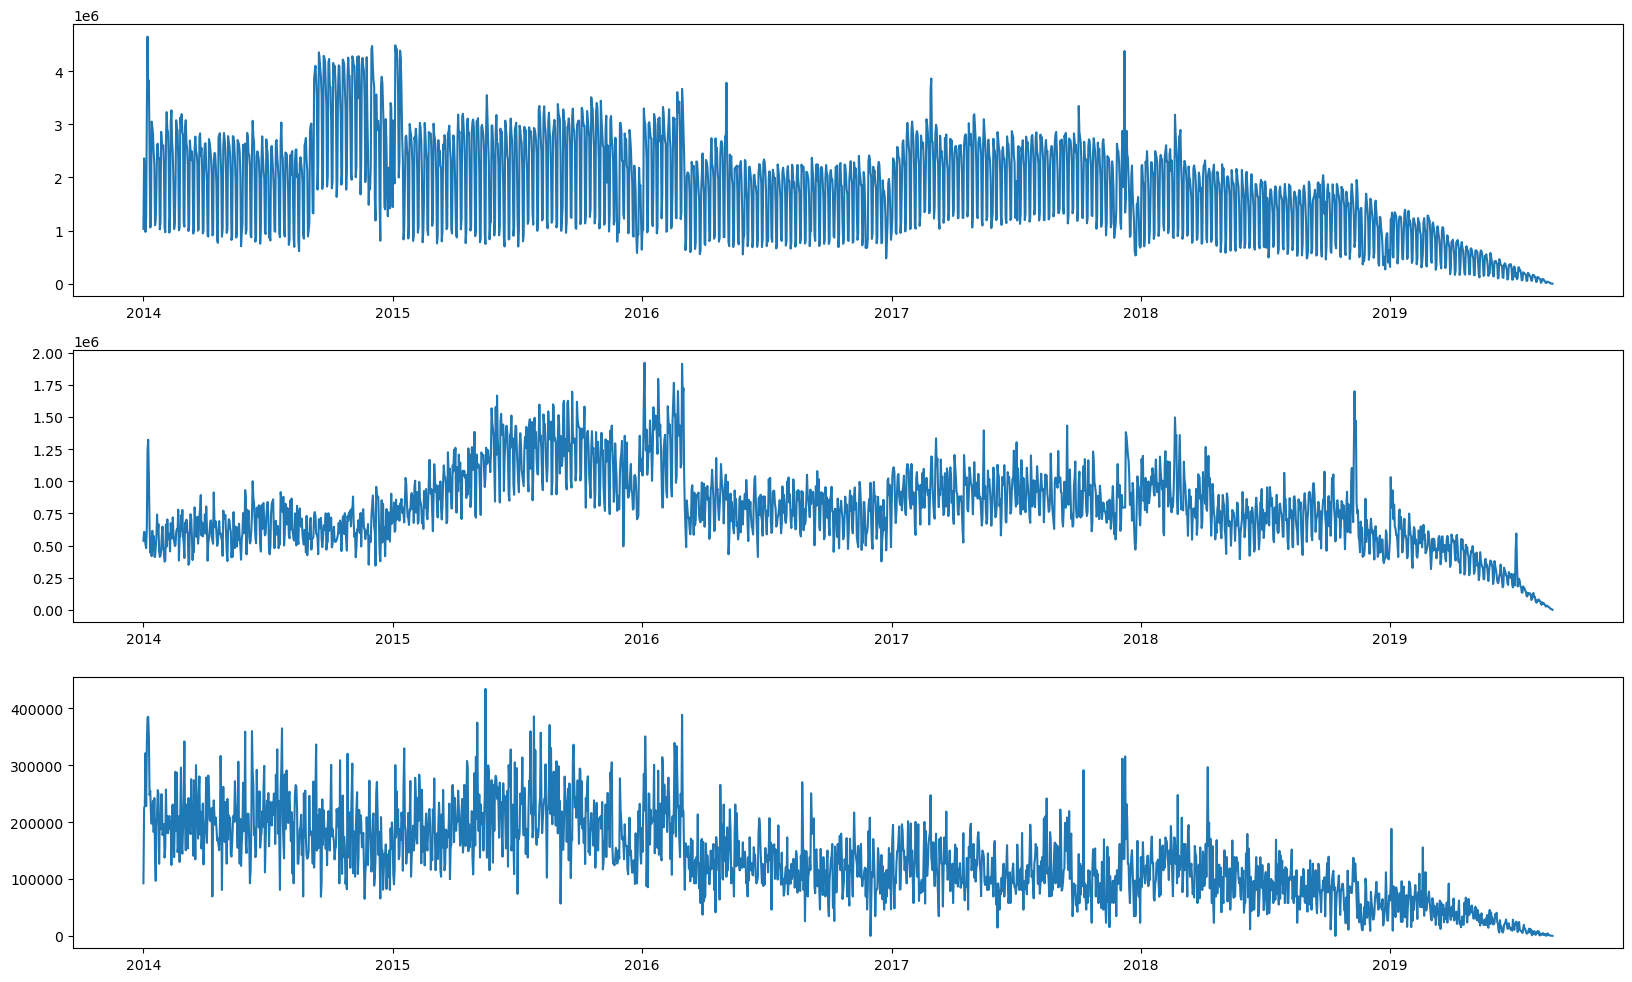

In [14]:
fig = plt.figure(figsize=(20,12))
plt.subplot(311)
plt.plot(df_desktop)
plt.subplot(312)
plt.plot(df_mobile)
plt.subplot(313)
plt.plot(df_tablet)
plt.show()

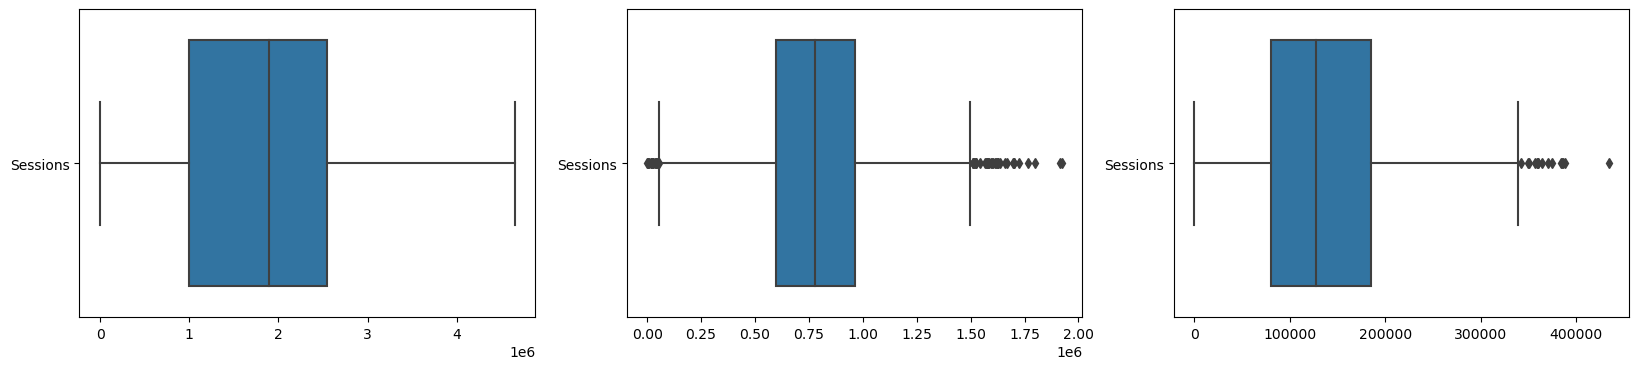

In [15]:
fig = plt.figure(figsize=(20,4))
plt.subplot(131)
sns.boxplot(df_desktop, orient='h')
plt.subplot(132)
sns.boxplot(df_mobile, orient='h')
plt.subplot(133)
sns.boxplot(df_tablet, orient='h')
plt.show()


---
# Stationarity tests

### Decomposition and Stationarity test for df_desktop

In [16]:
decomp = seasonal_decompose(df_desktop['Sessions'])
trend = decomp.trend
seasonal = decomp.seasonal
resid = decomp.resid


Decomposition of the endogenous variable


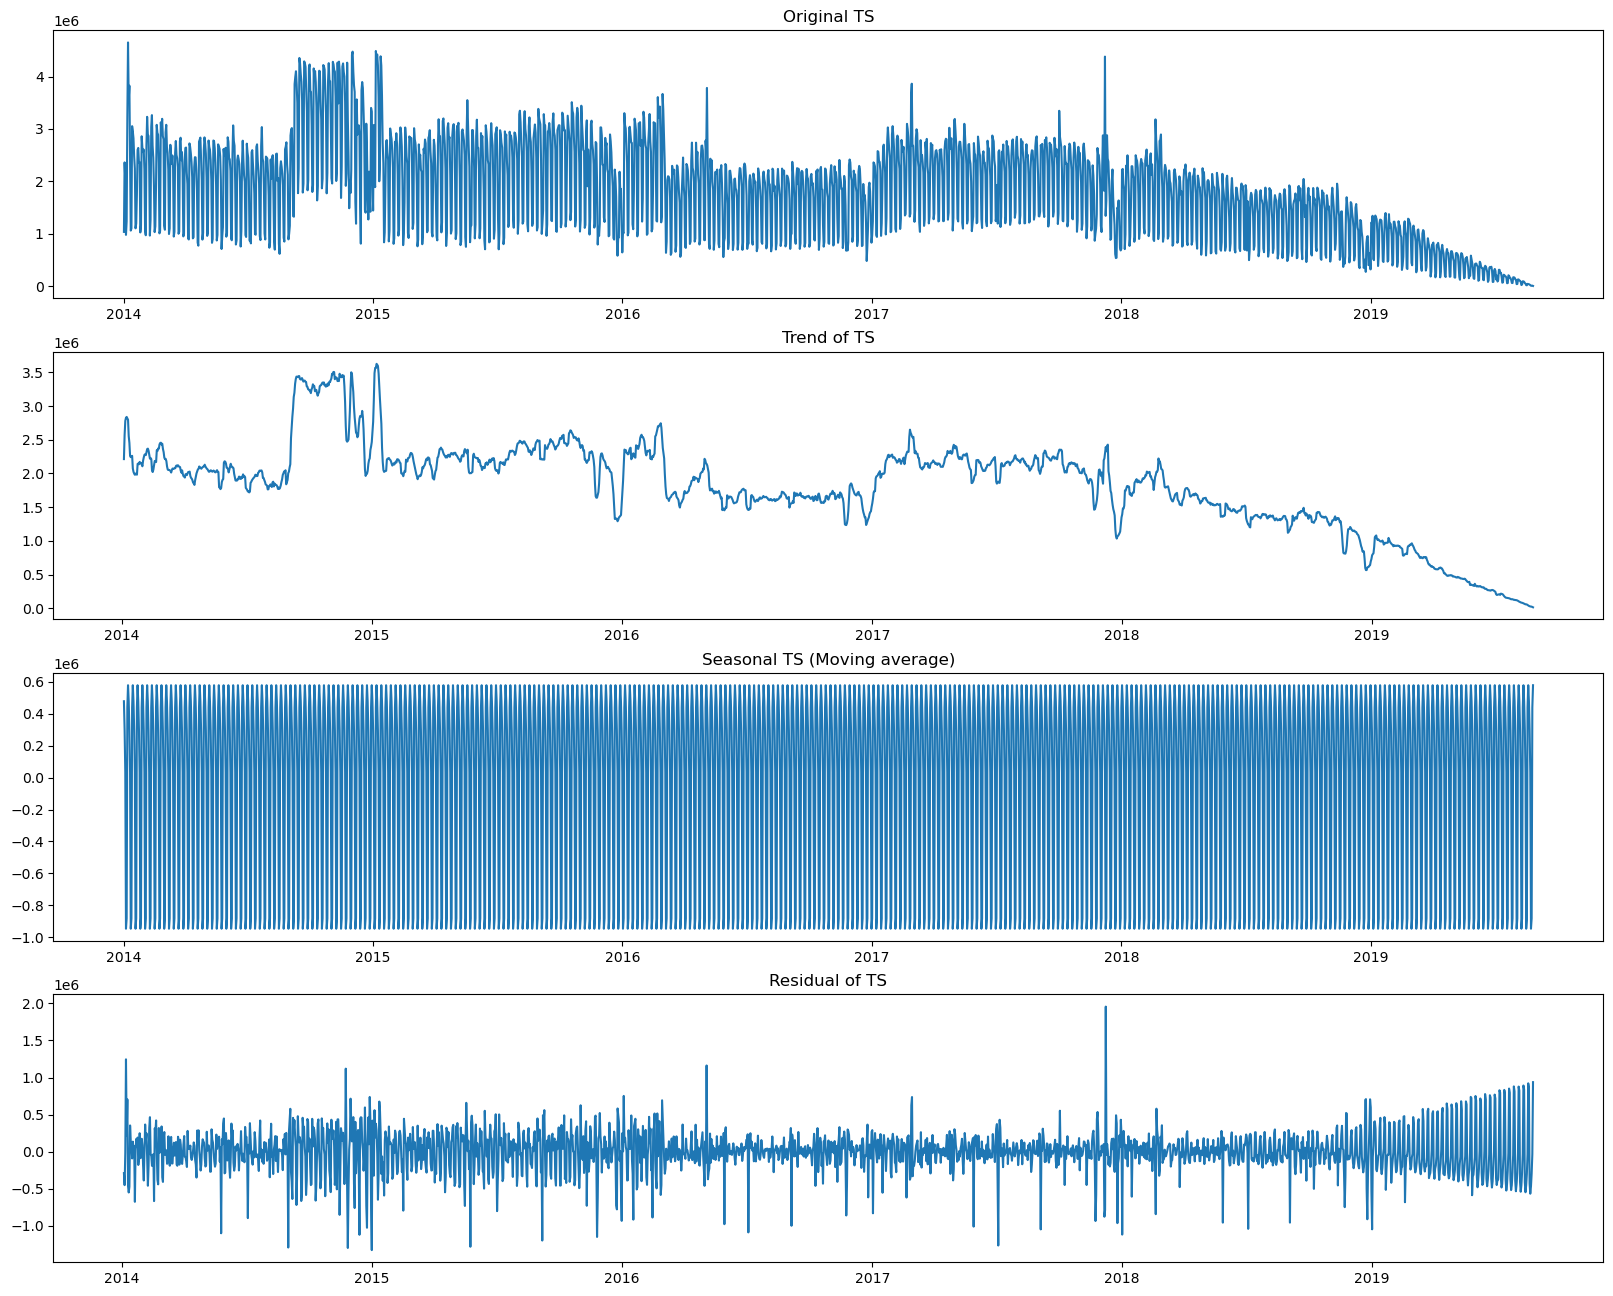

In [17]:
fig = plt.figure(figsize=(20,16))
plt.subplot(411)
plt.plot(df_desktop['Sessions'])
plt.title('Original TS')

plt.subplot(412)
plt.plot(trend)
plt.title('Trend of TS')

plt.subplot(413)
plt.plot(seasonal)
plt.title('Seasonal TS (Moving average)')

plt.subplot(414)
plt.plot(resid)
plt.title('Residual of TS')

print('\nDecomposition of the endogenous variable')

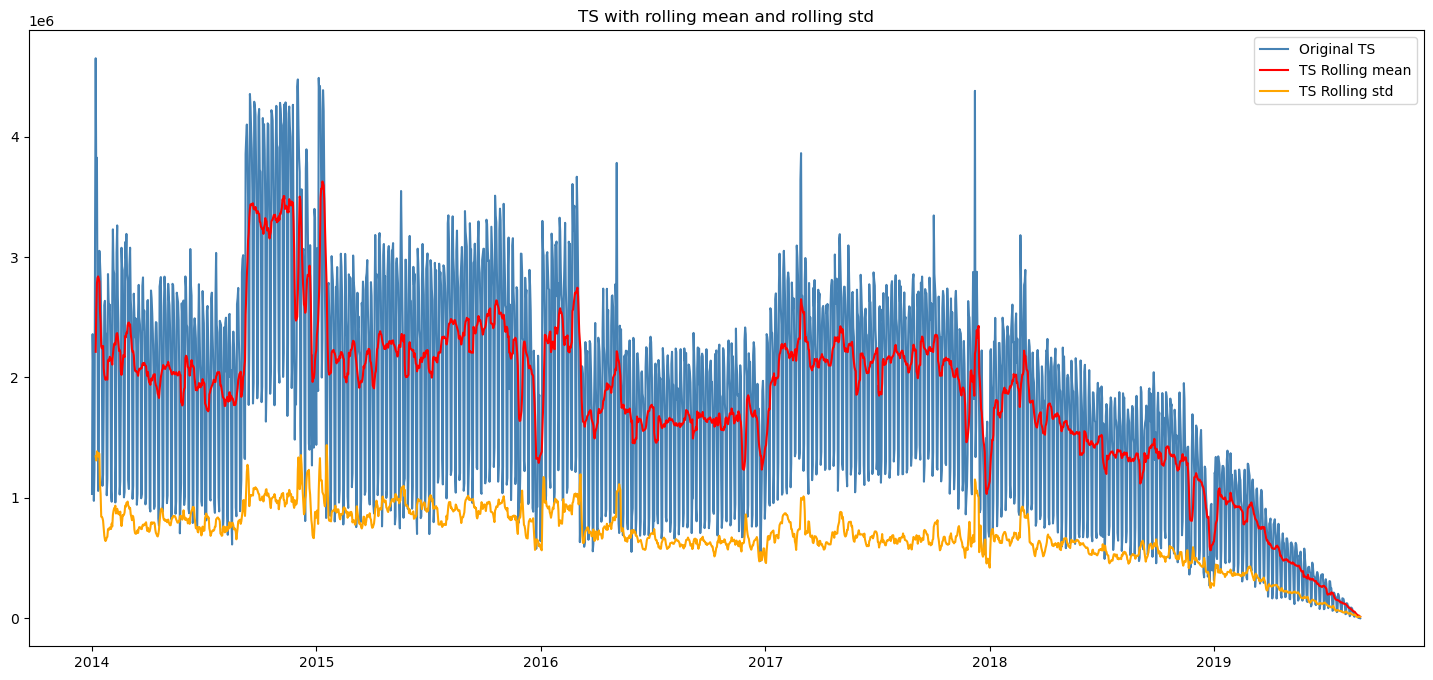

Results of the Augmented Dickey-Fuller test
Test stat.                -0.798487
p-value                    0.819566
#Lags chosen              26.000000
Total # observations    2038.000000
dtype: float64
Fail to reject Null-hypothesis (H0 accepted) -> Timeseries is NOT stationary.


In [18]:
def test_stationarity(timeseries, ssn_period: int, alpha: float = 0.05):
    # calculate rolling statistics
    rol_mean = timeseries.rolling(window=ssn_period).mean()
    rol_std = timeseries.rolling(window=ssn_period).std()
    
    # plot the ts and rolling metrics
    fig = plt.figure(figsize=(18,8))
    plt.plot(timeseries, color='steelblue', label='Original TS')
    plt.plot(rol_mean, color='red', label='TS Rolling mean')
    plt.plot(rol_std, color='orange', label='TS Rolling std')
    plt.legend(loc='best')
    plt.title("TS with rolling mean and rolling std")
    plt.show()

    print("Results of the Augmented Dickey-Fuller test")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test stat.', 'p-value', '#Lags chosen', 'Total # observations'])
    print(dfoutput)
    if dfoutput['p-value'] > alpha:
        print("Fail to reject Null-hypothesis (H0 accepted) -> Timeseries is NOT stationary.")
    else:
        print("Rejection of Null-hypothesis (H0 rejected) -> Timeseries is stationary.")
    

test_stationarity(df_desktop['Sessions'], 7, 0.05)  

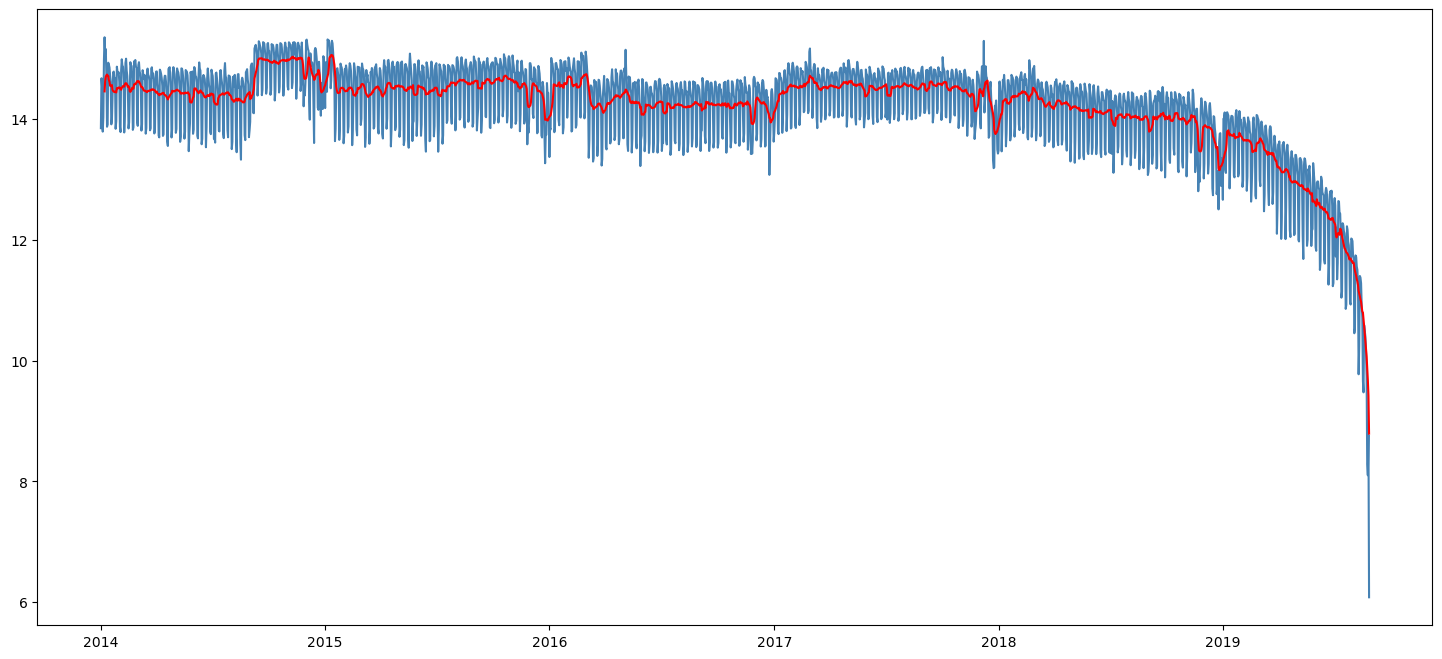

In [19]:
df_desktop_log = np.log(df_desktop)

moving_avg = df_desktop_log.rolling(window=7).mean()

fig = plt.figure(figsize=(18,8))
plt.plot(df_desktop_log, color='steelblue')
plt.plot(moving_avg, color='red')

In [20]:
# df_desktop_log.tail(50)

In [21]:
#df_desktop_log = df_desktop_log[df_desktop_log.index <= '2019-07-01']
#df_desktop_log = df_desktop_log[df_desktop_log.index <= '2019-01-01']
df_desktop_log = df_desktop_log[df_desktop_log.index <= '2018-10-01']

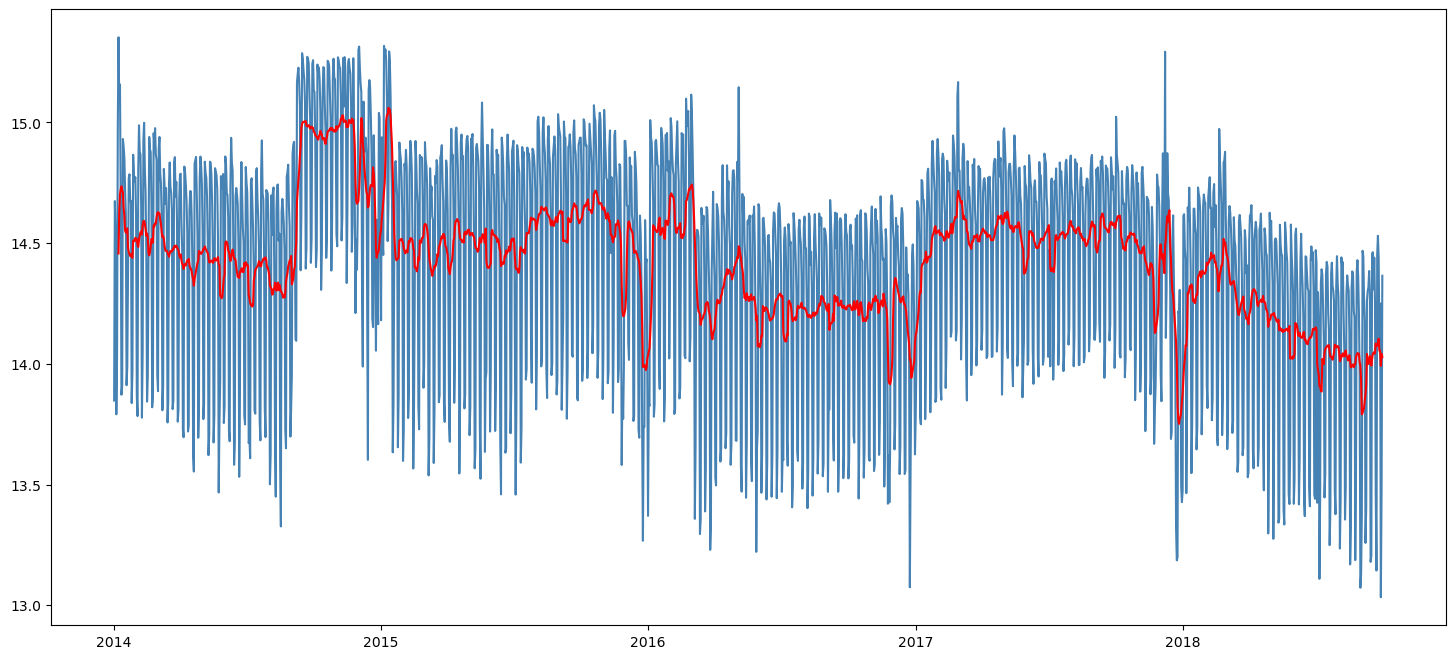

In [22]:
moving_avg = df_desktop_log.rolling(window=7).mean()

fig = plt.figure(figsize=(18,8))
plt.plot(df_desktop_log, color='steelblue')
plt.plot(moving_avg, color='red')

In [23]:
df_desktop_log_moving_mean_diff = df_desktop_log - moving_avg

df_desktop_log_moving_mean_diff.dropna(inplace=True)

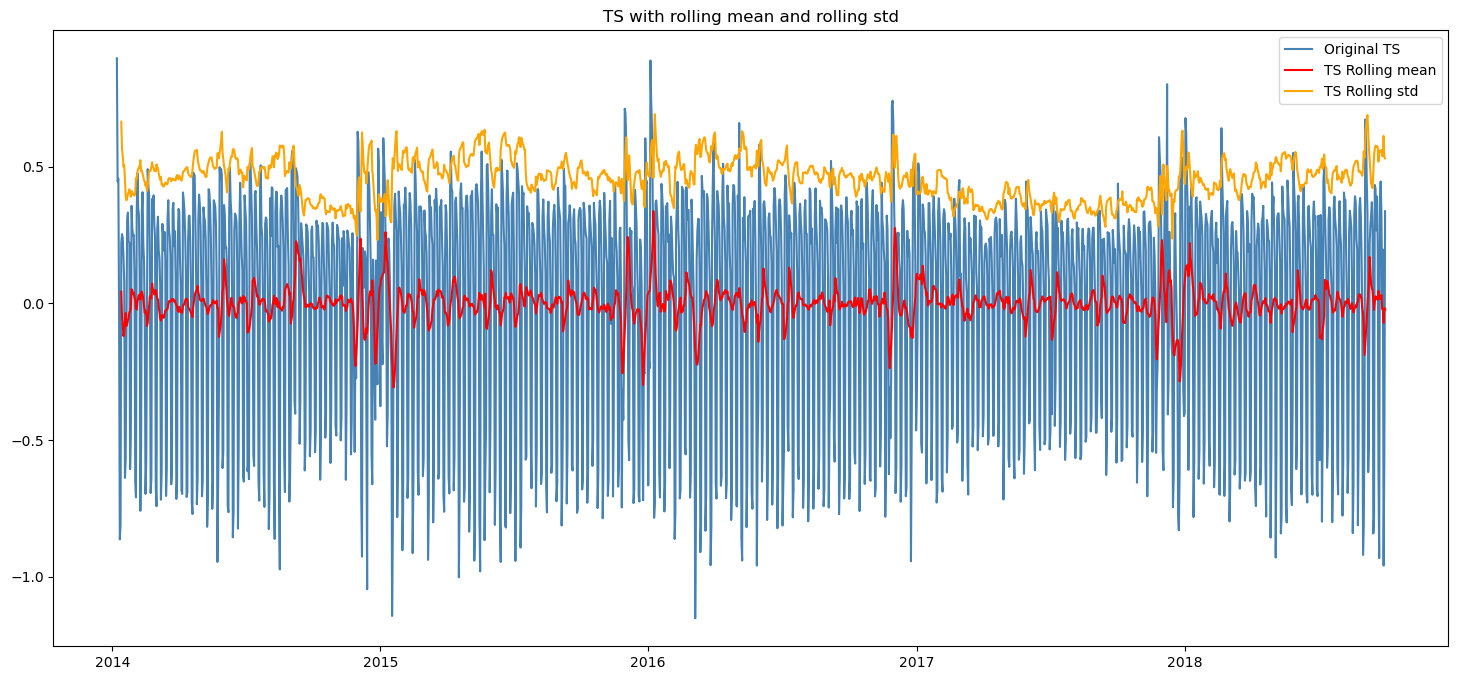

Results of the Augmented Dickey-Fuller test
Test stat.             -1.241551e+01
p-value                 4.249415e-23
#Lags chosen            2.300000e+01
Total # observations    1.705000e+03
dtype: float64
Rejection of Null-hypothesis (H0 rejected) -> Timeseries is stationary.


In [24]:
test_stationarity(df_desktop_log_moving_mean_diff, 7, 0.05)

In [25]:
# Saving the cleaned dataset for Time Series Forecasting

df_desktop_log.to_csv('df_desktop_final.csv')

#
### Decomposition and Stationarity test for df_mobile

In [26]:
decomp = seasonal_decompose(df_mobile['Sessions'])
trend = decomp.trend
seasonal = decomp.seasonal
resid = decomp.resid


Decomposition of the endogenous variable


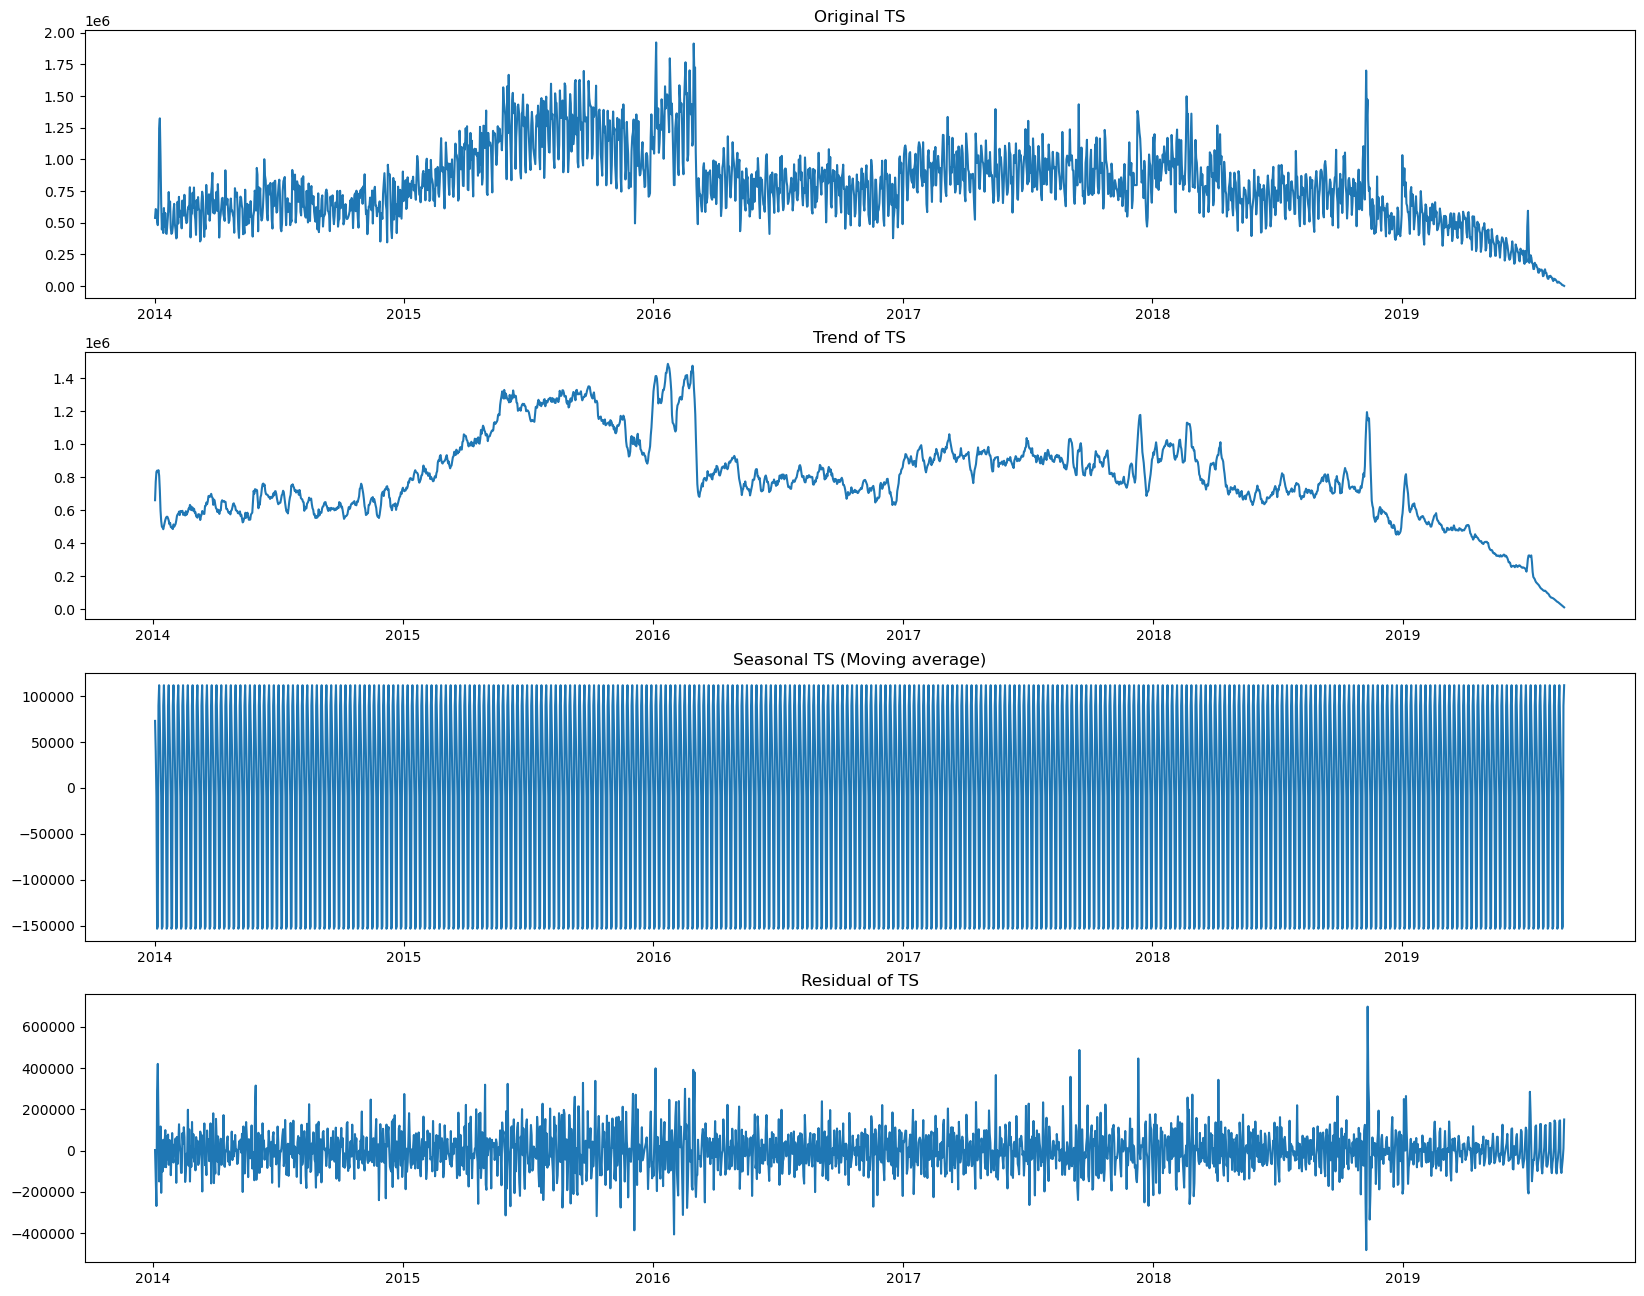

In [27]:
fig = plt.figure(figsize=(20,16))
plt.subplot(411)
plt.plot(df_mobile['Sessions'])
plt.title('Original TS')

plt.subplot(412)
plt.plot(trend)
plt.title('Trend of TS')

plt.subplot(413)
plt.plot(seasonal)
plt.title('Seasonal TS (Moving average)')

plt.subplot(414)
plt.plot(resid)
plt.title('Residual of TS')

print('\nDecomposition of the endogenous variable')

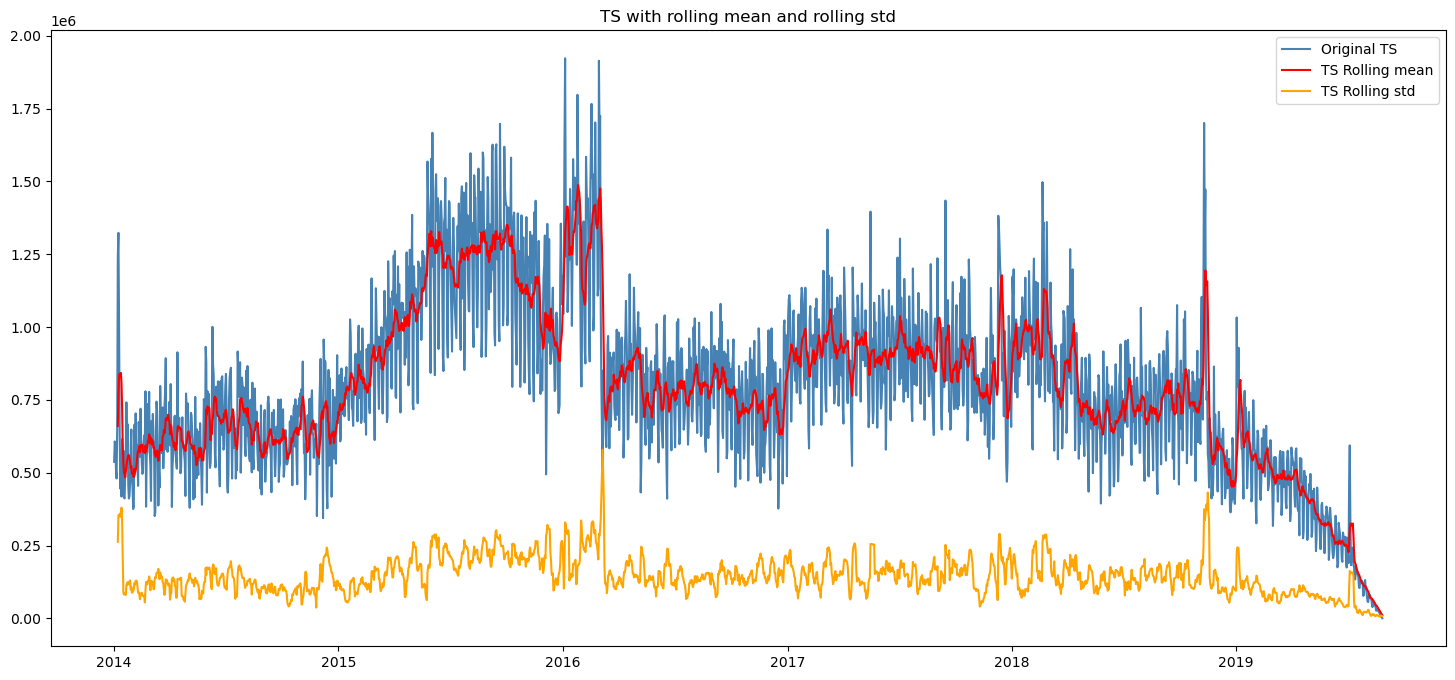

Results of the Augmented Dickey-Fuller test
Test stat.                -0.969361
p-value                    0.764275
#Lags chosen              26.000000
Total # observations    2038.000000
dtype: float64
Fail to reject Null-hypothesis (H0 accepted) -> Timeseries is NOT stationary.


In [28]:
test_stationarity(df_mobile['Sessions'], 7, 0.05) 

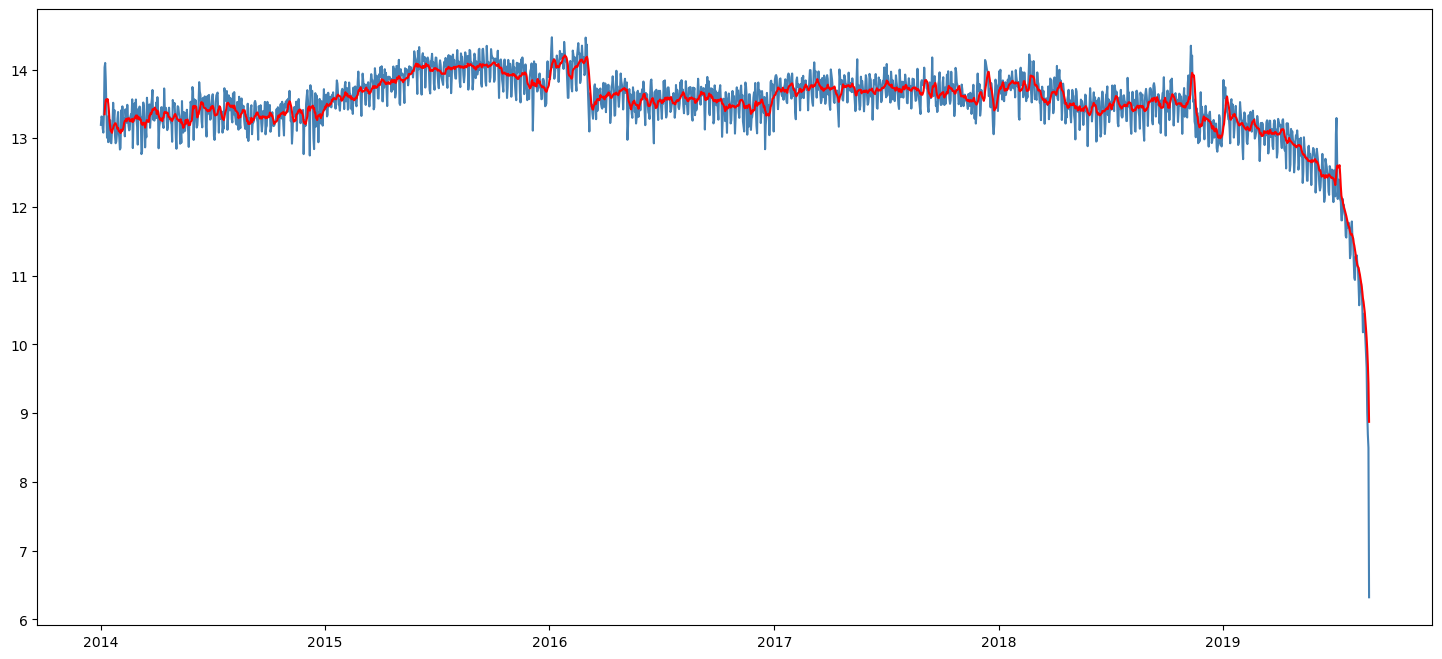

In [29]:
df_mobile_log = np.log(df_mobile)

moving_avg = df_mobile_log.rolling(window=7).mean()

fig = plt.figure(figsize=(18,8))
plt.plot(df_mobile_log, color='steelblue')
plt.plot(moving_avg, color='red')

In [30]:
df_mobile_log = df_mobile_log[df_mobile_log.index <= '2018-10-01']

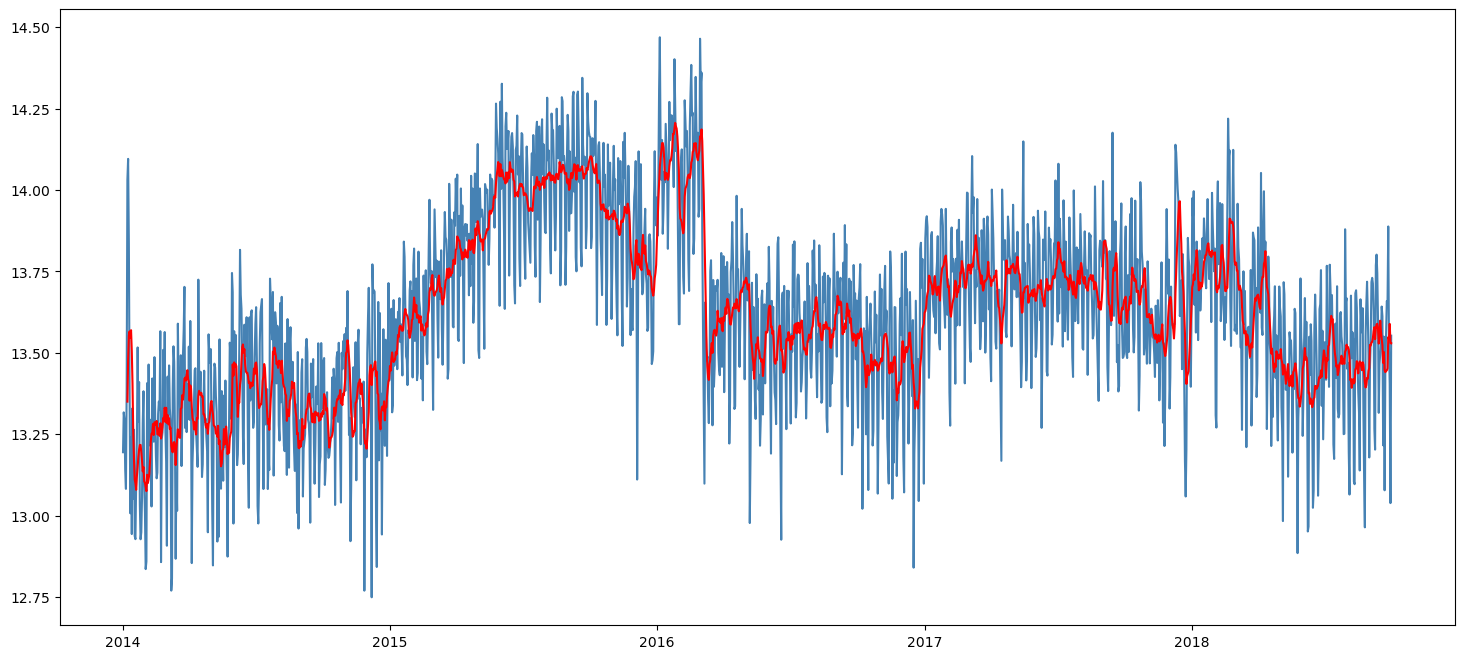

In [31]:
moving_avg = df_mobile_log.rolling(window=7).mean()

fig = plt.figure(figsize=(18,8))
plt.plot(df_mobile_log, color='steelblue')
plt.plot(moving_avg, color='red')

In [32]:
df_mobile_log_moving_mean_diff = df_mobile_log - moving_avg

df_mobile_log_moving_mean_diff.dropna(inplace=True)

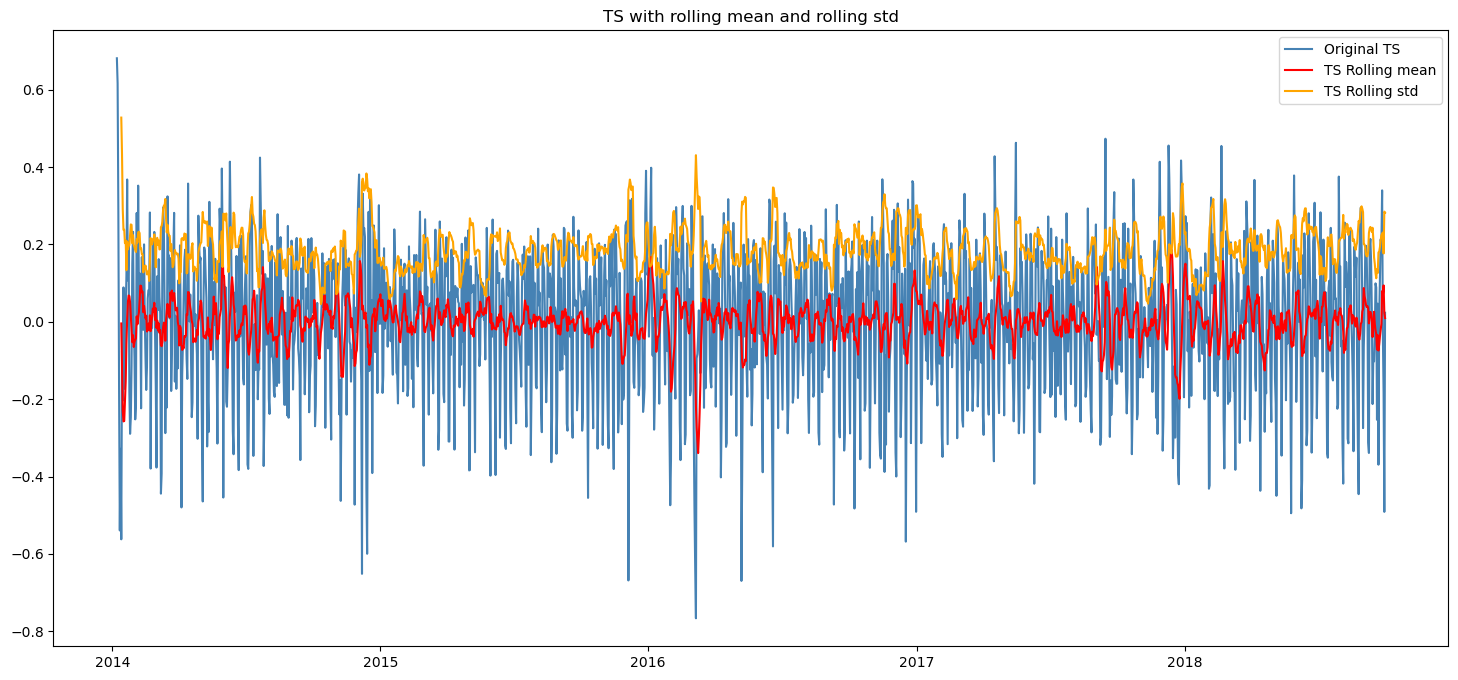

Results of the Augmented Dickey-Fuller test
Test stat.             -1.157998e+01
p-value                 2.958976e-21
#Lags chosen            2.500000e+01
Total # observations    1.703000e+03
dtype: float64
Rejection of Null-hypothesis (H0 rejected) -> Timeseries is stationary.


In [33]:
test_stationarity(df_mobile_log_moving_mean_diff, 7, 0.05)

In [34]:
# Saving the cleaned dataset for Time Series Forecasting

df_mobile_log.to_csv('df_mobile_final.csv')

#
### Decomposition and Stationarity test for df_tablet

In [35]:
decomp = seasonal_decompose(df_tablet['Sessions'])
trend = decomp.trend
seasonal = decomp.seasonal
resid = decomp.resid


Decomposition of the endogenous variable


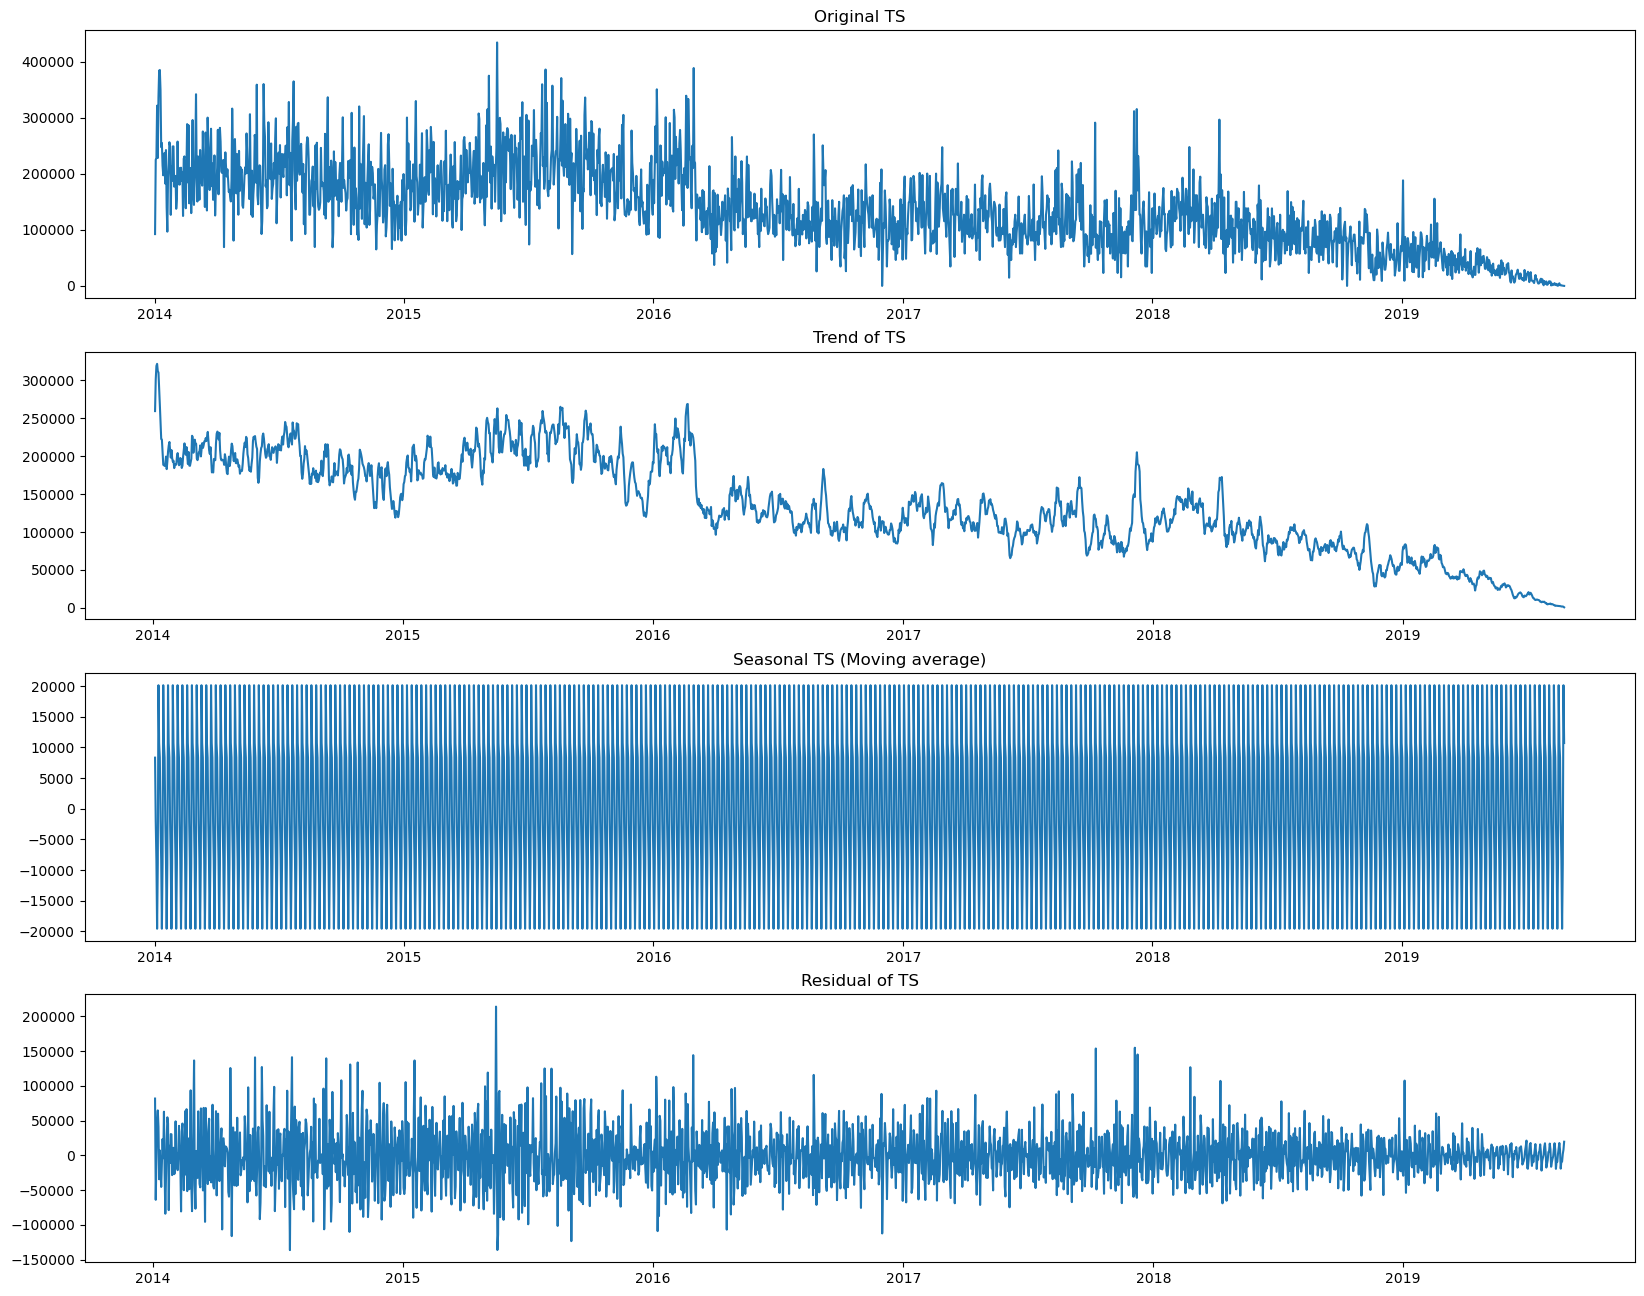

In [36]:
fig = plt.figure(figsize=(20,16))
plt.subplot(411)
plt.plot(df_tablet['Sessions'])
plt.title('Original TS')

plt.subplot(412)
plt.plot(trend)
plt.title('Trend of TS')

plt.subplot(413)
plt.plot(seasonal)
plt.title('Seasonal TS (Moving average)')

plt.subplot(414)
plt.plot(resid)
plt.title('Residual of TS')

print('\nDecomposition of the endogenous variable')

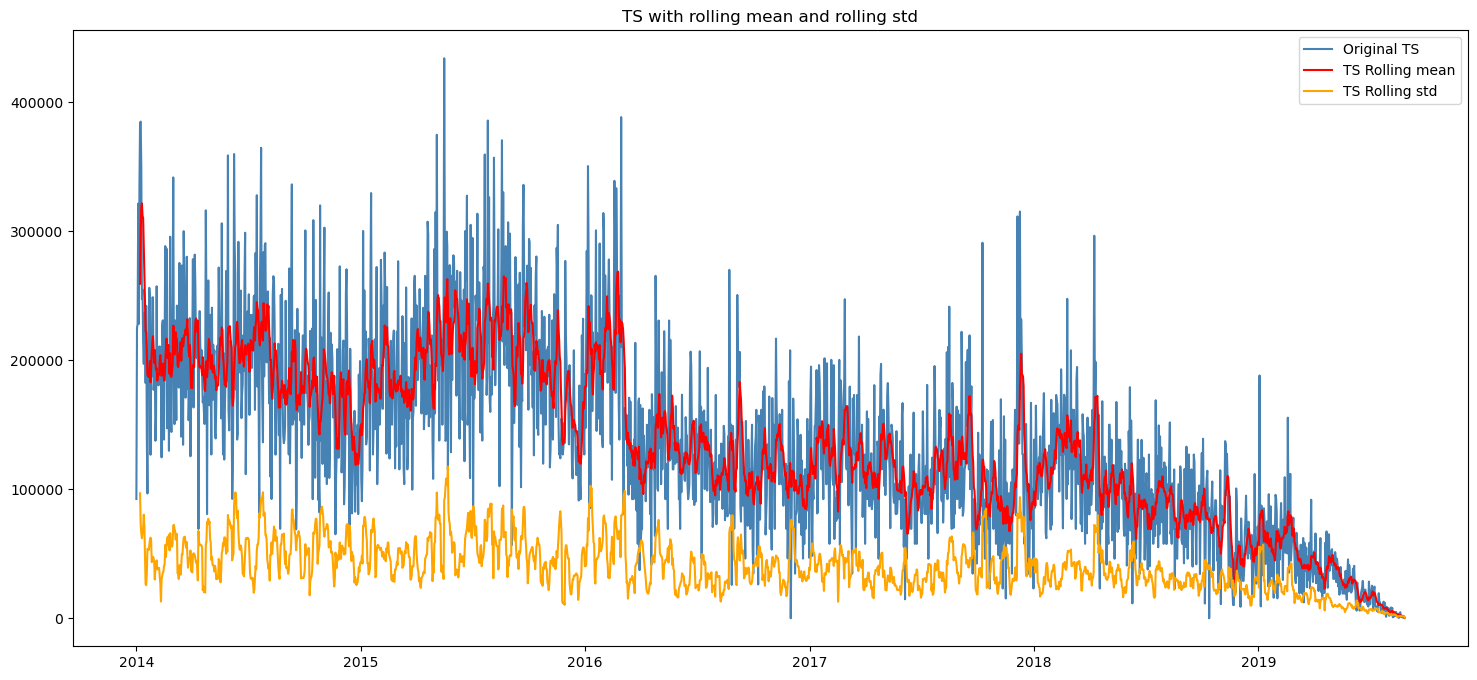

Results of the Augmented Dickey-Fuller test
Test stat.                -1.447026
p-value                    0.559535
#Lags chosen              26.000000
Total # observations    2038.000000
dtype: float64
Fail to reject Null-hypothesis (H0 accepted) -> Timeseries is NOT stationary.


In [37]:
test_stationarity(df_tablet['Sessions'], 7, 0.05) 

In [38]:
# Before log function is applied I've replaced two 0 values from the dataset with mean value, firstly because 
# I don't want to get infinity when applying log function, and second if I only add some epsilon value to this zeros, 
# I'll receive outlies once again.

df_tablet['Sessions'] = df_tablet['Sessions'].replace(0, mean_tablet)

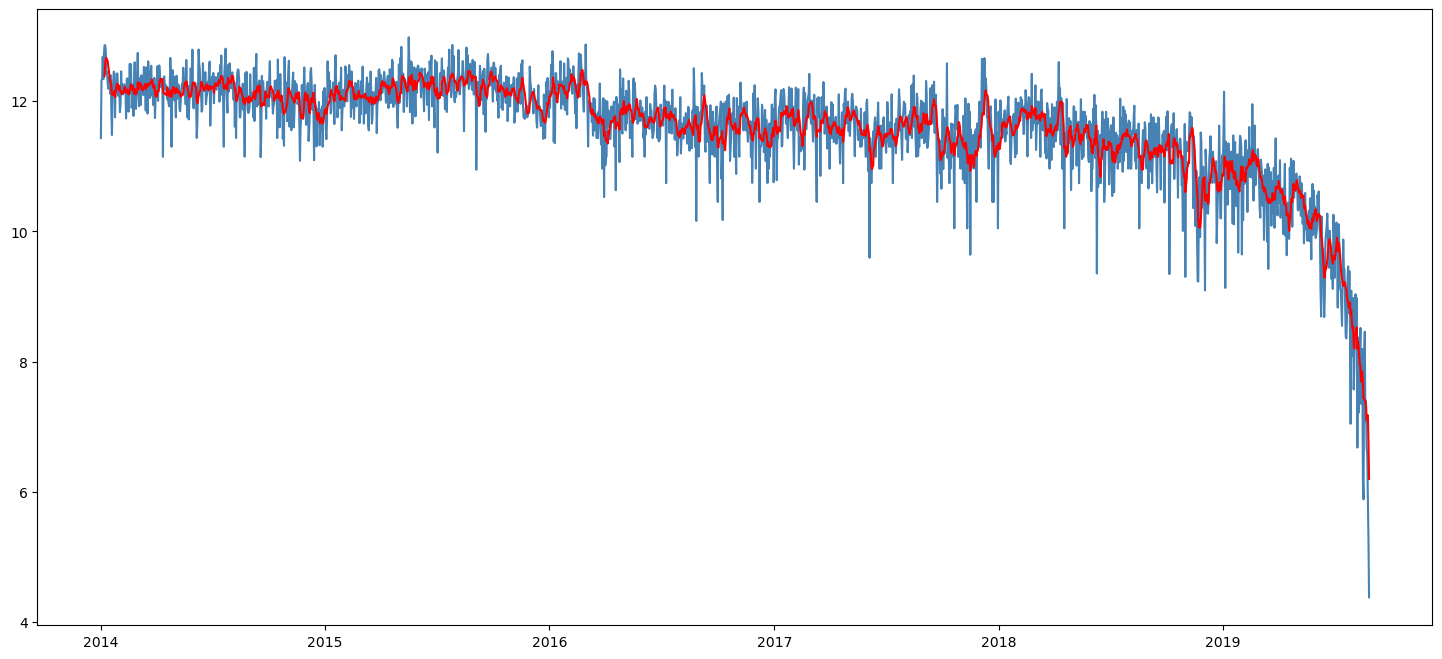

In [39]:
df_tablet_log = np.log(df_tablet)

moving_avg = df_tablet_log.rolling(window=7).mean()

fig = plt.figure(figsize=(18,8))
plt.plot(df_tablet_log, color='steelblue')
plt.plot(moving_avg, color='red')

In [40]:
df_tablet_log = df_tablet_log[df_tablet_log.index <= '2018-10-01']

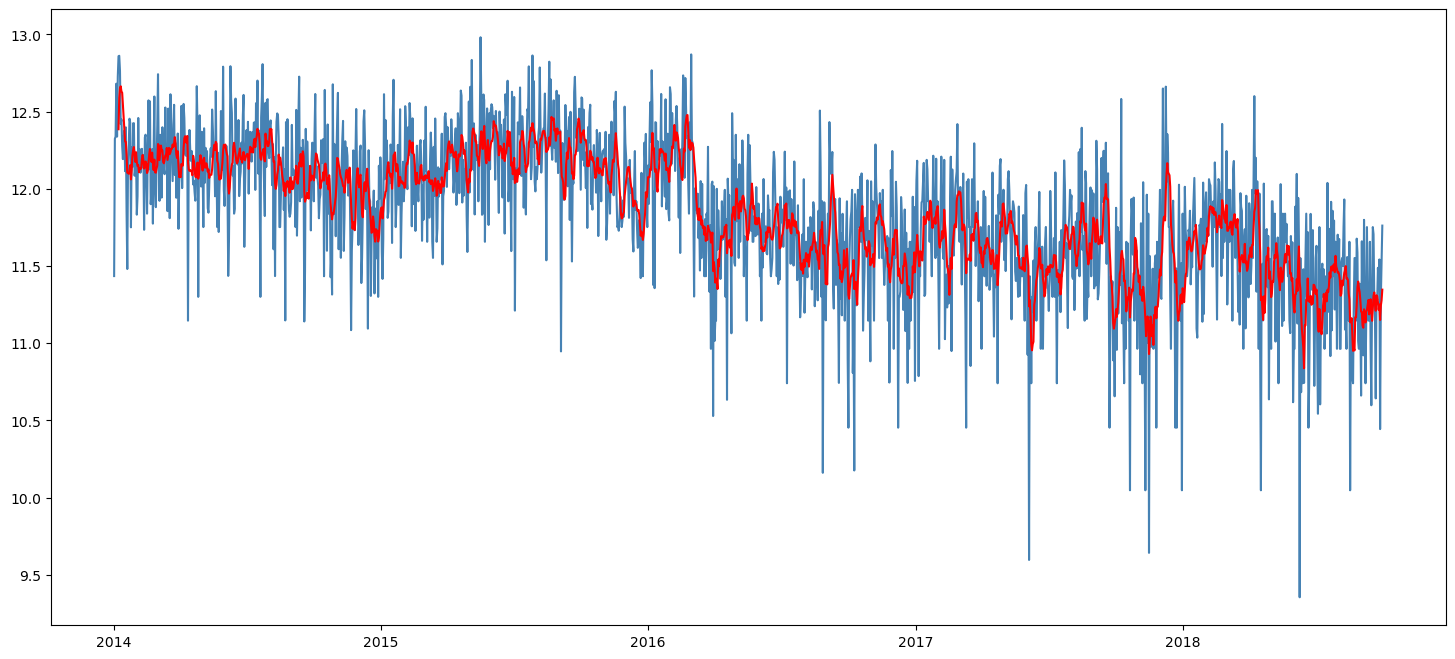

In [41]:
moving_avg = df_tablet_log.rolling(window=7).mean()

fig = plt.figure(figsize=(18,8))
plt.plot(df_tablet_log, color='steelblue')
plt.plot(moving_avg, color='red')

In [42]:
df_tablet_log_moving_mean_diff = df_tablet_log - moving_avg

df_tablet_log_moving_mean_diff.dropna(inplace=True)

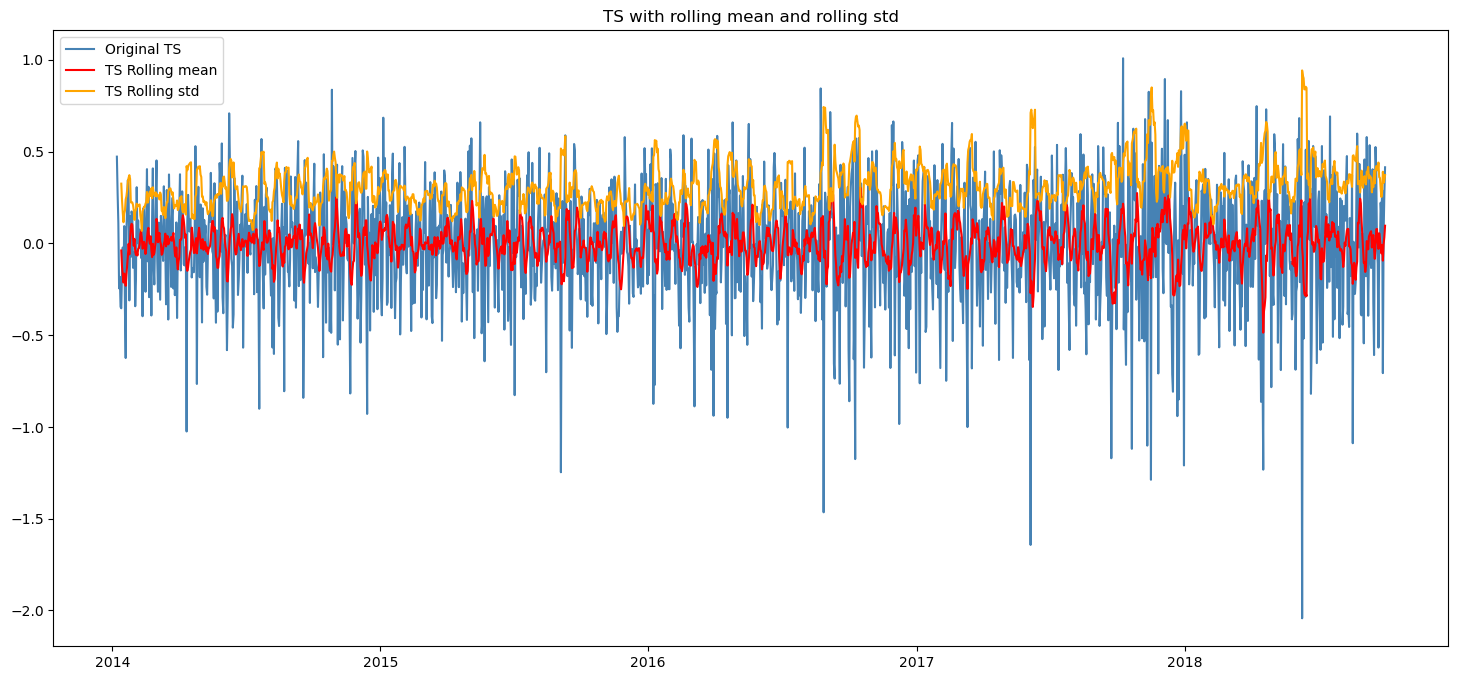

Results of the Augmented Dickey-Fuller test
Test stat.             -1.237885e+01
p-value                 5.082537e-23
#Lags chosen            2.400000e+01
Total # observations    1.704000e+03
dtype: float64
Rejection of Null-hypothesis (H0 rejected) -> Timeseries is stationary.


In [43]:
test_stationarity(df_tablet_log_moving_mean_diff, 7, 0.05)

In [44]:
# Saving the cleaned dataset for Time Series Forecasting

df_tablet_log.to_csv('df_tablet_final.csv')

# CONCLUSION from EDA, Data preprocessing and Data engineering:

---
## Handling outliers 
ONLY the most extreme outliers, shown as peak in the plots, were deleted and then imputed with mean value of the dataset.    

## Decomposition of the endogenous variable

**Trend Component**: Does not show persistent increasing or decreasing direction in the data.

**Seasonal Component**: This component captures regular patterns that occur over a period of 7 days.

**Residual Component**: This component represents the remaining random fluctuations in the data after removing the trend and seasonal components. Nothing particular can be seen at this point.      

## Stationarity test: 
All features failed the stationary test, so I appled logarithm function and I did all the additional steps to make it stationary. 
Before log function was applied, I've replaced two 0 values from the dataset with mean value, firstly because I don't want to get infinity when applying log function, and second if I only add some epsilon value to these zeros, I'll receive outlies once again.
    
Stationarity test after these transformations failed again. Here I assumed that the reason for this are the values in the last year - 2019, which are dropping sharply and they seemed as they were not real data. Since I have a large dataset, I decided to remove those values in order to obtain a better forecast. 

After this the dataset passed the stationarity test and it is ready for Time Series Forecasting with ARIMA, SARIMA and PROPHET models.  

I'm saving the files in order to train the models on clean dataset in additional notebooks.
